In [2]:
import numpy as np
import scipy as sp
import scipy.linalg as splin
import scipy.sparse as sps
import scipy.sparse.linalg as spslin
import scipy.optimize as opt
import math
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
#Plot parameters
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.style.use(['dark_background'])

np.set_printoptions(suppress='true')

In [3]:
def Rtheta(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def Gauss(x, a, mean, sigma):
    return a * np.exp(-(x - mean)**2 / (2 * sigma**2))

def psi_QW(case):
    R1 = np.zeros((numstates, numstates), dtype=float)
    R2 = np.zeros((numstates, numstates), dtype=float)
    for i_L in range(L):
        if i_L<L//2 : theta1 = theta1_L; theta2 = theta2_L
        else : 
            if case=="point" or case=="line": theta1 = theta2_L; theta2 = theta1_L
            if case=="obc": theta1 = theta1_R; theta2 = theta2_R             
        R1[2*i_L:2*(i_L+1), 2*i_L:2*(i_L+1)] = Rtheta(theta1/2)
        R2[2*i_L:2*(i_L+1), 2*i_L:2*(i_L+1)] = Rtheta(theta2/2)

    U = R1 @ S @ R2 @ M
    Evol = U    
    psi = np.copy(psi0)
    for i_T in range(T) :
        psi = Evol @ psi
        psi = psi/np.linalg.norm(psi)
    return psi

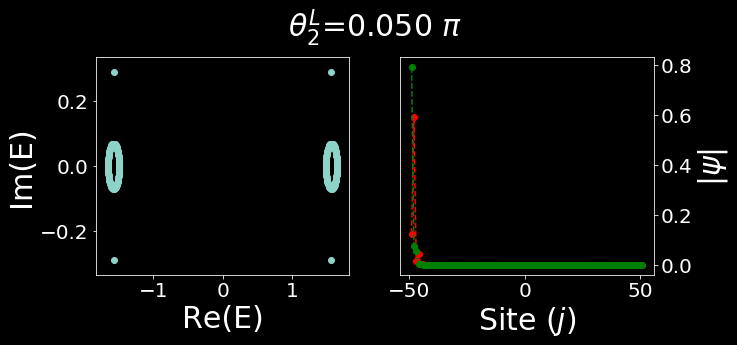

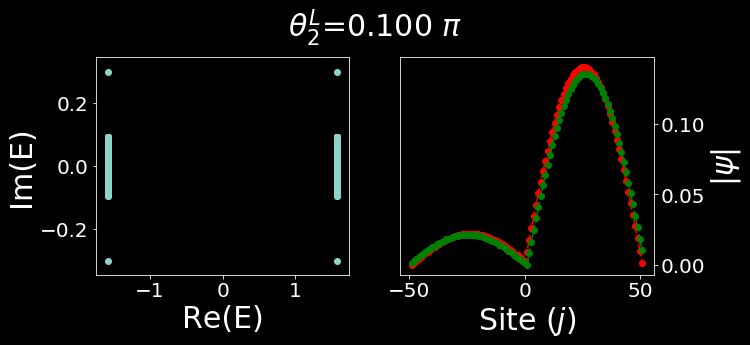

In [5]:
# Spectrum and eigenstate
L = 101
numstates = 2*L
dtheta = 0.001
theta_list = np.pi*np.array([0.05, 0.1]) 
gamma = 0.3
i_state = 0
PBC = 1 
case = "point"

if case=="point": theta1_L = 0.9*np.pi; theta2_R = theta1_L    
if case=="line": theta1_L = 0.05*np.pi; theta2_R = theta1_L
if case=="obc": theta1_L = 0.45*np.pi; theta1_R = 0.1*np.pi; theta2_R = 1.45*np.pi
    

S = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L-2),-2)
S_obc = np.copy(S)
if PBC == 1:  S[2*L-2, 0] = 1; S[1, 2*L-1] = 1
M = np.kron(np.eye((L)), np.array([[np.exp(gamma), 0], [0, np.exp(-gamma)]]))

E_listH = np.zeros((numstates, len(theta_list)), dtype = complex)
psi_table = np.zeros((numstates, len(theta_list)), dtype=complex)

for i_theta in range(len(theta_list)):    
    theta2_L = theta_list[i_theta]
    if case=="point" or case=="line": theta1_R = theta2_L
    R1 = np.zeros((numstates, numstates), dtype=float)
    R2 = np.zeros((numstates, numstates), dtype=float)
    for i_L in range(L):
        if i_L<L//2 : theta1 = theta1_L; theta2 = theta2_L
        else : theta1 = theta1_R; theta2 = theta2_R
        R1[2*i_L:2*(i_L+1), 2*i_L:2*(i_L+1)] = Rtheta(theta1/2)
        R2[2*i_L:2*(i_L+1), 2*i_L:2*(i_L+1)] = Rtheta(theta2/2)
        
    U = R1 @ S @ R2 @ M
    D, V = np.linalg.eig(U)
    DH = 1j*np.log(D)
    DH = DH[np.argsort(DH.imag)]
    E_listH[:, i_theta] = DH
     
    U_obc = R1 @ S_obc @ R2 @ M
    Dobc, Vobc = np.linalg.eig(U_obc)
    Dh = 1j*np.log(Dobc)
    Vobc= Vobc[:, np.argsort(-Dh.imag)]
    Dh = Dh[np.argsort(-Dh.imag)]
    psi_table[:, i_theta] = Vobc[:, i_state]
    if (abs(Dh.imag[i_state] - Dh.imag[i_state+1])<1e-10) and (Dh.real[i_state] > Dh.real[i_state+1]): psi_table[:, i_theta] = Vobc[:,i_state+1]

    fig = plt.figure(figsize=(10, 4)) 
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(E_listH[:, i_theta].real, E_listH[:, i_theta].imag)
    ax.set_xlabel("Re(E)", fontsize=30)
    ax.set_ylabel("Im(E)", fontsize=30)
    ax.set_title(r"$\theta_{2}^{L}$=%.3f $\pi$" %(theta2_L/np.pi), fontsize=30, x=1.1, y=1.05, pad=10)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(np.arange(L)-L//2+1, np.abs(psi_table[2*np.arange(L), i_theta]), "--or")
    ax.plot(np.arange(L)-L//2+1, np.abs(psi_table[2*np.arange(L)+1, i_theta]), "--og")
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlabel(r"Site ($j$)", fontsize=30)
    ax.set_ylabel(r"$|\psi|$", fontsize=30)


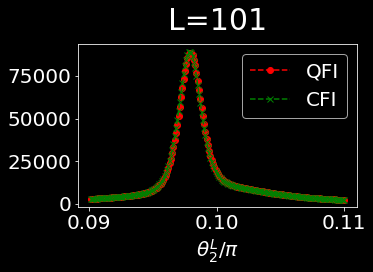

In [6]:
# QFI of steady state (domain wall)
L = 101
numstates = 2*L
dtheta = 0.0001*np.pi
theta_list =  np.pi*np.linspace(0.09, 0.11, round(0.02*np.pi/dtheta)+1)
gamma = 0.3
i_state = 0
PBC = 0
case = "point"

if case=="point": theta1_L = 0.9*np.pi; theta2_R = theta1_L    
if case=="line": theta1_L = 0.05*np.pi; theta2_R = theta1_L
if case=="obc": theta1_L = 0.45*np.pi; theta1_R = 0.1*np.pi; theta2_R = 1.45*np.pi
    
V0 = np.zeros((numstates, numstates), dtype=complex)
for ii in range(numstates) : V0[ii,ii] = 1
pi = np.zeros((numstates), dtype=object)
for ii in range(numstates) :
    pi[ii] = np.outer(V0[:,ii], V0[:,ii].conj())

S = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L-2),-2)
S_obc = np.copy(S)
if PBC == 1:  S[2*L-2, 0] = 1; S[1, 2*L-1] = 1
M = np.kron(np.eye((L)), np.array([[np.exp(gamma), 0], [0, np.exp(-gamma)]]))

QFI_table = np.zeros((len(theta_list)-1, 3), dtype=float)
psi = np.zeros((numstates), dtype=complex)
for i_theta in range(len(theta_list)):
    theta2_L = theta_list[i_theta]
    if case=="point" or case=="line": theta1_R = theta2_L
    R1 = np.zeros((numstates, numstates), dtype=float)
    R2 = np.zeros((numstates, numstates), dtype=float)
    for i_c in range(L):
        if i_c < L//2 : theta1 = theta1_L; theta2 = theta2_L
        else :  theta1 = theta1_R; theta2 = theta2_R 
        R1[2*i_c:2*(i_c+1), 2*i_c:2*(i_c+1)] = Rtheta(theta1/2)
        R2[2*i_c:2*(i_c+1), 2*i_c:2*(i_c+1)] = Rtheta(theta2/2)

    U = R1 @ S @ R2 @ M
    D, V = np.linalg.eig(U)
    Dh = 1j*np.log(D)
    V = V[:, np.argsort(-(Dh.imag))]
    Dh = Dh[np.argsort(-(Dh.imag))]

    psi0 = np.copy(psi)
    psi = V[:, i_state]
    if (abs(Dh.imag[i_state] - Dh.imag[i_state+1])<1e-10) and (Dh.real[i_state] > Dh.real[i_state+1]): psi = V[:, i_state+1]

    if i_theta>0:
        overlap = (np.abs(np.inner(psi.conj(),psi0)))**2
        CFI = 0
        for ii in range(numstates//2):
            if abs(psi0.T.conj()@(pi[2*ii]+pi[2*ii+1])@psi0) > 1e-10: 
                CFI = CFI + ((psi.T.conj()@(pi[2*ii]+pi[2*ii+1])@psi - psi0.T.conj()@(pi[2*ii]+pi[2*ii+1])@psi0)**2) / (psi0.T.conj()@(pi[2*ii]+pi[2*ii+1])@psi0)
        QFI_table[i_theta-1, :] = np.array([theta2_L/np.pi, 4*(1 - overlap)/(dtheta**2), CFI.real/(dtheta**2)])
    
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(QFI_table[:, 0], QFI_table[:, 1], "--or", label="QFI")
ax.plot(QFI_table[:, 0], QFI_table[:, 2], "--xg", label="CFI")
ax.set_xlabel(r"$\theta_2^L/\pi$")
ax.legend(loc="best")
ax.set_title("L=%d" %L, fontsize=30, x=0.5, y=1.05)
plt.show() 
 

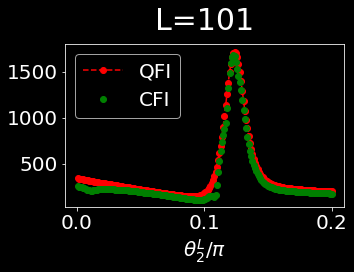

In [8]:
# QW evolution
L = 101
T = round((L-1)/2)
numstates = 2*L
x0 = L//2
dtheta = 0.001*np.pi
theta_list = np.pi*np.linspace(0.0, 0.2, round(0.2*np.pi/dtheta)+1)
gamma = 0.3
PBC = 0
case = "point"

psi0 = np.zeros((numstates), dtype=complex)
if case=="point":
    theta1_L = 0.9*np.pi; theta2_R = theta1_L
    psi0[2*x0] = 0; psi0[2*x0+1] = 1    
if case=="line":    
    theta1_L = 0.05*np.pi; theta2_R = theta1_L
    psi0[2*x0] = 1; psi0[2*x0+1] = -1
if case=="obc":
    theta1_L = 0.45*np.pi; theta1_R = 0.1*np.pi; theta2_R = 1.45*np.pi
    psi0[2*x0+1] = 1
psi0 = psi0/np.linalg.norm(psi0)

S = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L-2),-2)
S_obc = np.copy(S)
if PBC == 1:  S[2*L-2, 0] = 1; S[1, 2*L-1] = 1
M = np.kron(np.eye((L)), np.array([[np.exp(gamma), 0], [0, np.exp(-gamma)]]))

V0 = np.zeros((numstates, numstates), dtype=complex)
for ii in range(numstates) : V0[ii,ii] = 1
pi = np.zeros((numstates), dtype=object)
for ii in range(numstates) :
    pi[ii] = np.outer(V0[:,ii], V0[:,ii].conj())
    
psimat = np.zeros((len(theta_list), numstates), dtype=complex)
QFI_table = np.zeros((len(theta_list)-1, 3), dtype=float)
for i_theta in range(len(theta_list)):
    theta2_L = theta_list[i_theta]
    if case==2 or case==3: theta1_R = theta2_L
    psi = psi_QW(case)
    psimat[i_theta, :] = psi

    if i_theta>0:
        CFI = 0
        overlap  = (np.abs(np.inner(psimat[i_theta, :].conj(),psimat[i_theta-1, :])))**2
        for ii in range(numstates//2):
            if abs(psimat[i_theta-1, :].T.conj()@(pi[2*ii]+pi[2*ii+1])@psimat[i_theta-1, :]) > 1e-10: 
                CFI = CFI + ((psimat[i_theta, :].T.conj()@(pi[2*ii]+pi[2*ii+1])@psimat[i_theta, :] - psimat[i_theta-1, :].T.conj()@(pi[2*ii]+pi[2*ii+1])@psimat[i_theta-1, :])**2) \
                        / (psimat[i_theta-1, :].T.conj()@(pi[2*ii]+pi[2*ii+1])@psimat[i_theta-1, :])           

        QFI_table[i_theta-1, :] = np.array([theta2_L/np.pi, 4*(1 - overlap)/(dtheta**2), CFI.real/(dtheta**2)])
            
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(QFI_table[:,0],QFI_table[:,1], "--or", label="QFI")
ax.plot(QFI_table[:,0],QFI_table[:,2], "og", label="CFI")
ax.set_xlabel(r"$\theta_2^L/\pi$")
ax.legend(loc="best")
ax.set_title("L=%d" %L, fontsize=30, x=0.5, y=1.05)
plt.show()

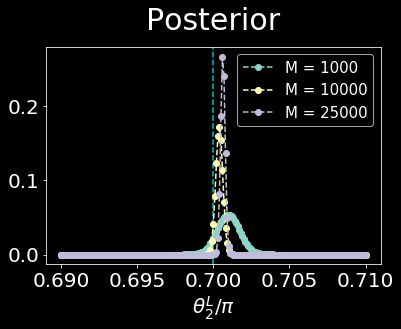

In [9]:
# Bayesian posterior update
L = 31
T = round((L-1)/2)
numstates = 2*L
x0 = L//2
gamma = 0.3
i_state = 0
PBC = 1
dT = 1
PBC = 1
n_data = 1000
case = "obc"

psi0 = np.zeros((numstates), dtype=complex)
if case=="point":
    theta1_L = 0.9*np.pi; theta2_R = theta1_L
    theta_exp_list = np.pi*np.linspace(0.0, 0.2, round(0.2/0.01)+1)
    case_idx=3; ini = 1
    psi0[2*x0+1] = 1    
if case=="line":    
    theta1_L = 0.05*np.pi; theta2_R = theta1_L
    theta_exp_list = np.pi*np.linspace(0.6, 0.8, round(0.2/0.01)+1)
    case_idx=2; ini = 1
    psi0[2*x0] = 1; psi0[2*x0+1] = -1
if case=="obc":
    theta1_L = 0.45*np.pi; theta1_R = 0.1*np.pi; theta2_R = 1.45*np.pi
    theta_exp_list = np.pi*np.linspace(0.6, 0.8, round(0.2/0.01)+1)
    case_idx=1; ini = 2
    psi0[2*x0+1] = 1
psi0 = psi0/np.linalg.norm(psi0)

sheet = 10
theta_real = theta_exp_list[sheet]
dtheta = 0.0001*np.pi
theta_list = np.linspace(theta_real-0.01*np.pi, theta_real+0.01*np.pi, round(0.02*np.pi/dtheta)+1)

V0 = np.zeros((numstates, numstates), dtype=complex)
for ii in range(numstates) : V0[ii,ii] = 1
pi = np.zeros((numstates), dtype=object)
for ii in range(numstates): pi[ii] = np.outer(V0[:,ii], V0[:,ii].conj())

S = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L-2),-2)
S_obc = S
if PBC == 1:  S[2*L-2, 0] = 1; S[1, 2*L-1] = 1
M = np.kron(np.eye((L)), np.array([[np.exp(gamma), 0], [0, np.exp(-gamma)]]))

lhood_list = np.zeros((len(theta_list)), dtype=float)
prior_list = np.ones((len(theta_list)))
post_list = np.zeros((len(theta_list)), dtype=float)
prob_list = np.zeros((L), dtype=float)
post_table = np.zeros((len(theta_list), 4))
post_table[:, 0] = theta_list/np.pi

fig, ax = plt.subplots(figsize=(6, 4))
ax.axvline(x=theta_real/np.pi, linestyle='--', color='c')
ax.set_title("Posterior", fontsize=30, x=0.5, y=1.05)

i_post = 1
site_tot = np.zeros((L), dtype=int)
for i_data in range(9):        
    if i_data==8: xls = pd.ExcelFile("../Data/"+str(case)+"/Initial_state"+str(ini)+"/C"+str(case_idx)+"_I"+str(ini)+"_measurement"+str(10000)+".xlsx")
    else: xls = pd.ExcelFile("../Data/"+str(case)+"/Initial_state"+str(ini)+"/C"+str(case_idx)+"_I"+str(ini)+"_measurement"+str((i_data+1)*500)+".xlsx")
    df = pd.read_excel(xls, sheet_name=xls.sheet_names[sheet], header=None, index_col=None)
    table = df.to_numpy()
    site_tot += table[T-1, 2:2*T+3].astype(int) 
n_tot = np.sum(site_tot).astype(int)
n_sample = (n_tot//n_data).astype(int)

p_list = np.zeros((L), dtype=float)    
for ii in range(L): p_list[ii] = site_tot[ii]/n_tot
for ii in range(1, L):  p_list[ii] += p_list[ii-1]
site_table = np.zeros((n_sample, L), dtype=int)
for i_sample in range(n_sample):
    np.random.seed()
    random_list = np.random.random(n_data) 
    for i_exp in range(n_data):
        i_site = np.flatnonzero(p_list >= random_list[i_exp])[0]
        site_table[i_sample, i_site] += 1 

lhood_list = np.zeros((len(theta_list)), dtype=float)
prior_list = np.ones((len(theta_list)))
post_list = np.zeros((len(theta_list)), dtype=float)
prob_list = np.zeros((L), dtype=float)
for i_sample in range(n_sample):
    site_list = site_table[i_sample, :].astype(int)
    n_exp = int(np.sum(site_list))

    for i_theta in range(len(theta_list)):
        theta2_L = theta_list[i_theta]
        if case==2 or case==3: theta1_R = theta2_L
        psi = psi_QW(case)

        for ii in range(L): prob_list[ii] = (psi.T.conj() @ (pi[2*ii]+pi[2*ii+1]) @ psi).real
        multi_coeff = 1
        for jj in range(L): multi_coeff *= math.comb(n_exp-sum(site_list[:jj]), site_list[jj]) * (prob_list[jj])**(site_list[jj])
        lhood_list[i_theta] = multi_coeff

    post_list = lhood_list * prior_list
    post_list /= np.sum(post_list)
    prior_list = post_list

    x = theta_list/np.pi; y = post_list
    mean = sum(x * y) / sum(y); sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    popt,pcov = opt.curve_fit(Gauss, x, y, p0=[max(y), mean, sigma], maxfev=20000)    
    
    if i_sample==0 or i_sample==9 or i_sample==24:
        ax.plot(x, y, "--o", label="M = %d" %((i_sample+1)*n_data))
        ax.set_xlabel(r"$\theta_2^L/\pi$")
        ax.legend(loc='best', fontsize=15)
        post_table[:, i_post] = y
        i_post += 1

[ 0.23758743 -0.00330815  0.00105503]
[0.21017051 0.02753751 0.00119266]
[0.19351436 0.05897334 0.00129532]
[0.17079073 0.08902633 0.00146767]
[0.16353976 0.12831257 0.00153275]
[0.16212969 0.15371391 0.00154609]
[0.18485362 0.1961923  0.00135601]
[0.22039176 0.21987259 0.00113734]
[0.26627291 0.25396657 0.00094136]
[0.32631462 0.2823423  0.00076815]
[0.28085981 0.31153594 0.00089204]
[0.54926827 0.34507531 0.00045659]
[0.75620808 0.3771461  0.00033142]
[0.77054424 0.40848457 0.00032278]
[0.63569936 0.43871564 0.00039422]
[0.51749194 0.47207659 0.00048428]
[0.42997739 0.49994367 0.000583  ]
[0.3444458  0.53588375 0.00072773]
[0.28542119 0.5646637  0.00087817]
[0.26917624 0.59643808 0.00093119]
[0.27300042 0.62540841 0.00091818]


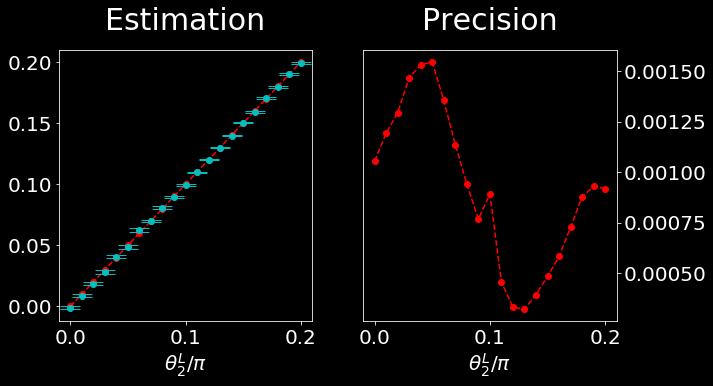

In [16]:
# Bayesian estimation and precision
L = 31
T = round((L-1)/2)
numstates = 2*L
x0 = L//2
gamma = 0.3
dtheta = 0.0001*np.pi
dT = 1
PBC = 0
n_data = 1000
case = "point"

psi0 = np.zeros((numstates), dtype=complex)
if case=="point":
    theta1_L = 0.9*np.pi; theta2_R = theta1_L
    theta_exp_list = np.pi*np.linspace(0.0, 0.2, round(0.2/0.01)+1)
    case_idx=3; ini = 1
    psi0[2*x0+1] = 1    
if case=="line":    
    theta1_L = 0.05*np.pi; theta2_R = theta1_L
    theta_exp_list = np.pi*np.linspace(0.6, 0.8, round(0.2/0.01)+1)
    case_idx=2; ini = 1
    psi0[2*x0] = 1; psi0[2*x0+1] = -1
if case=="obc":
    theta1_L = 0.45*np.pi; theta1_R = 0.1*np.pi; theta2_R = 1.45*np.pi
    theta_exp_list = np.pi*np.linspace(0.6, 0.8, round(0.2/0.01)+1)
    case_idx=1; ini = 2
    psi0[2*x0+1] = 1
psi0 = psi0/np.linalg.norm(psi0)

S = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L-2),-2)
S_obc = S
if PBC == 1:  S[2*L-2, 0] = 1; S[1, 2*L-1] = 1
S_up = np.diag(np.resize([1,0],2*L-2),2) + np.diag(np.resize([0,1],2*L),0)
S_dn = np.diag(np.resize([0,1],2*L-2),-2) + np.diag(np.resize([1,0],2*L),0)
S_up_obc = S_up; S_dn_obc = S_dn
if PBC == 1: S_up[2*L-2, 0] = 1; S_dn[1, 2*L-1] = 1
M = np.kron(np.eye((L)), np.array([[np.exp(gamma), 0], [0, np.exp(-gamma)]]))

V0 = np.zeros((numstates, numstates), dtype=complex)
for ii in range(numstates) : V0[ii,ii] = 1
pi = np.zeros((numstates), dtype=object)
for ii in range(numstates) :
    pi[ii] = np.outer(V0[:,ii], V0[:,ii].conj())
    
psimat = np.zeros((len(theta_exp_list), numstates), dtype=complex)
sigma_table = np.zeros((len(theta_exp_list), 4))
for i_theta_exp, theta_exp in enumerate(theta_exp_list): 
    theta_list = np.linspace(theta_exp-0.02*np.pi, theta_exp+0.02*np.pi, round(0.02*np.pi/dtheta)+1)
    sheet = i_theta_exp
        
    theta2_L = theta_exp
    if case==2 or case==3: theta1_R = theta2_L
    psi1 = psi_QW(case)     
    theta2_L = theta_exp + dtheta
    if case==2 or case==3: theta1_R = theta2_L
    psi2 = psi_QW(case)    
    overlap  = (np.abs(np.inner(psi2.conj(), psi1)))**2
    Fq = 4*(1 - overlap)/(dtheta**2)
        
    site_tot = np.zeros((L), dtype=int)
    for i_data in range(9):        
        if i_data==8: xls = pd.ExcelFile("../Data/"+str(case)+"/Initial_state"+str(ini)+"/C"+str(case_idx)+"_I"+str(ini)+"_measurement"+str(10000)+".xlsx")
        else: xls = pd.ExcelFile("../Data/"+str(case)+"/Initial_state"+str(ini)+"/C"+str(case_idx)+"_I"+str(ini)+"_measurement"+str((i_data+1)*500)+".xlsx")
        df = pd.read_excel(xls, sheet_name=xls.sheet_names[sheet], header=None, index_col=None)
        table = df.to_numpy()
        site_tot += table[T-1, 2:2*T+3].astype(int) 
    n_tot = np.sum(site_tot).astype(int)
    n_sample = (n_tot//n_data).astype(int)
    
    p_list = np.zeros((L), dtype=float)    
    for ii in range(L): p_list[ii] = site_tot[ii]/n_tot
    for ii in range(1, L):  p_list[ii] += p_list[ii-1]
    site_table = np.zeros((n_sample, L), dtype=int)
    for i_sample in range(n_sample):
        np.random.seed()
        random_list = np.random.random(n_data) 
        for i_exp in range(n_data):
            i_site = np.flatnonzero(p_list >= random_list[i_exp])[0]
            site_table[i_sample, i_site] += 1
    
    lhood_list = np.zeros((len(theta_list)), dtype=float)
    prior_list = np.ones((len(theta_list)))
    post_list = np.zeros((len(theta_list)), dtype=float)
    prob_list = np.zeros((L), dtype=float)
    for i_sample in range(n_sample):
        site_list = site_table[i_sample, :].astype(int)
        n_exp = int(np.sum(site_list))

        for i_theta in range(len(theta_list)):
            theta2_L = theta_list[i_theta]
            if case==2 or case==3: theta1_R = theta2_L
            psi = psi_QW(case)

            for ii in range(L): prob_list[ii] = (psi.T.conj() @ (pi[2*ii]+pi[2*ii+1]) @ psi).real
            multi_coeff = 1
            for jj in range(L): multi_coeff *= math.comb(n_exp-sum(site_list[:jj]), site_list[jj]) * (prob_list[jj])**(site_list[jj])
            lhood_list[i_theta] = multi_coeff

        post_list = lhood_list * prior_list
        post_list /= np.sum(post_list)
        prior_list = post_list

    x = theta_list; y = post_list
    mean = sum(x * y) / sum(y); sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    popt,pcov = opt.curve_fit(Gauss, x, y, p0=[max(y), mean, sigma], maxfev=20000)
    print(popt)

    sigma_table[i_theta_exp, :] = np.array([theta_exp/np.pi, popt[1]/np.pi, popt[2], 1/np.sqrt(n_exp*(i_sample+1)*Fq)])

#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax.plot(x/np.pi, y, "or", label=r"$\theta_{2}^{L}$=%.2f $\pi$" %(theta_exp/np.pi))
#     ax.plot(x/np.pi, (max(y)) * np.exp(-(x - popt[1])**2 / (2 * (popt[2])**2)), "--c")
#     ax.set_xlabel(r"$\theta_2^L/\pi$")
#     ax.legend(loc='best', fontsize=15)
#     plt.show()

fig = plt.figure(figsize=(10, 5)) 
ax = fig.add_subplot(1, 2, 1)
ax.plot(sigma_table[:, 0], sigma_table[:, 0], "--or")
ax.errorbar(sigma_table[:, 0], sigma_table[:, 1], yerr=sigma_table[:, 2], capsize=10, fmt="oc", ecolor = "c")
ax.set_xlabel(r"$\theta_2^L/\pi$")
ax.set_title("Estimation", fontsize=30, x=0.5, y=1.05)
ax = fig.add_subplot(1, 2, 2)
ax.plot(sigma_table[:, 0], sigma_table[:, 2], "--or")
ax.set_xlabel(r"$\theta_2^L/\pi$")
ax.set_title("Precision", fontsize=30, x=0.5, y=1.05)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.show()